In [2]:
# Cature imge through webcam

import cv2

# Open the webcam video capture object
cap = cv2.VideoCapture(0)

# Define the video codec and output filename
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # Check if frame is read correctly
    if not ret:
        break

    # Display the captured frame
    cv2.imshow('Webcam', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

    # Write the frame to the output video file
    out.write(frame)

# Release the capture object and video writer
cap.release()
out.release()
cv2.destroyAllWindows()



In [2]:
# Apply filter, Edge detection and canny edge detection 

import cv2
import sys
import numpy

PREVIEW  = 0  # Preview Mode
BLUR     = 1  # Blurring Filter
FEATURES = 2  # Corner Feature Detector
CANNY    = 3  # Canny Edge Detector

feature_params = dict(maxCorners=500, qualityLevel=0.2, minDistance=15, blockSize=9)
s = 0
if len(sys.argv) > 1:
    s = sys.argv[1]

image_filter = PREVIEW
alive = True

win_name = "Camera Filters"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
result = None

source = cv2.VideoCapture(0)

while alive:
    has_frame, frame = source.read()
    if not has_frame:
        break

    frame = cv2.flip(frame, 1)

    if image_filter == PREVIEW:
        result = frame
    elif image_filter == CANNY:
        result = cv2.Canny(frame, 140, 150)
    elif image_filter == BLUR:
        result = cv2.blur(frame, (13, 13))
    elif image_filter == FEATURES:
        result = frame
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(frame_gray, **feature_params)
        if corners is not None:
             # Ensure corners are integers for circle function
            
            for x, y in numpy.int32(corners).reshape(-1, 2):
                cv2.circle(result, (x, y), 10, (0, 255, 0), 1)

    cv2.imshow(win_name, result)

    key = cv2.waitKey(1)
    if key == ord("Q") or key == ord("q") or key == 27:
        alive = False
    elif key == ord("C") or key == ord("c"):
        image_filter = CANNY
    elif key == ord("B") or key == ord("b"):
        image_filter = BLUR
    elif key == ord("F") or key == ord("f"):
        image_filter = FEATURES
    elif key == ord("P") or key == ord("p"):
        image_filter = PREVIEW

source.release()
cv2.destroyWindow(win_name)

Reading reference image: im1.jpg
Reading image to align: im2.jpg


Text(0.5, 1.0, 'Scanned Form')

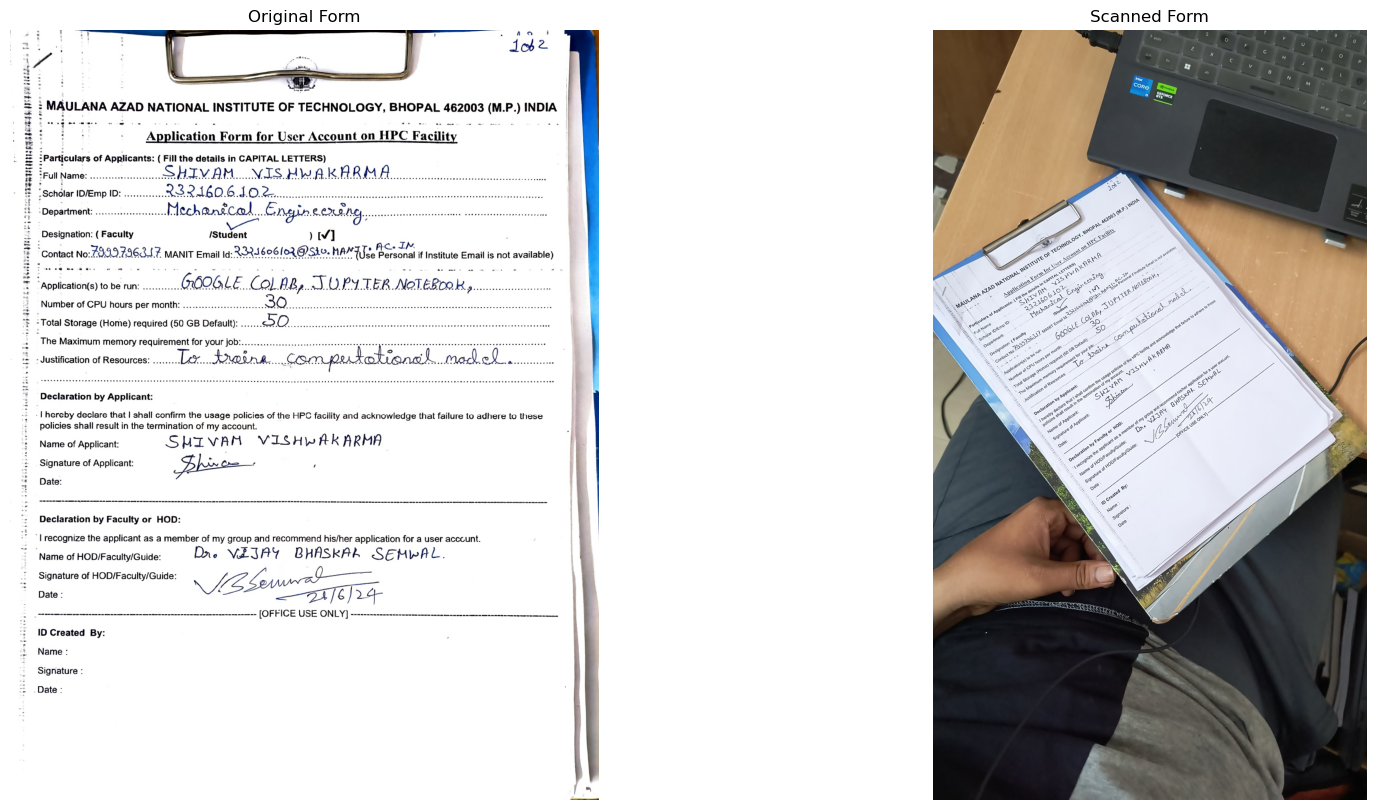

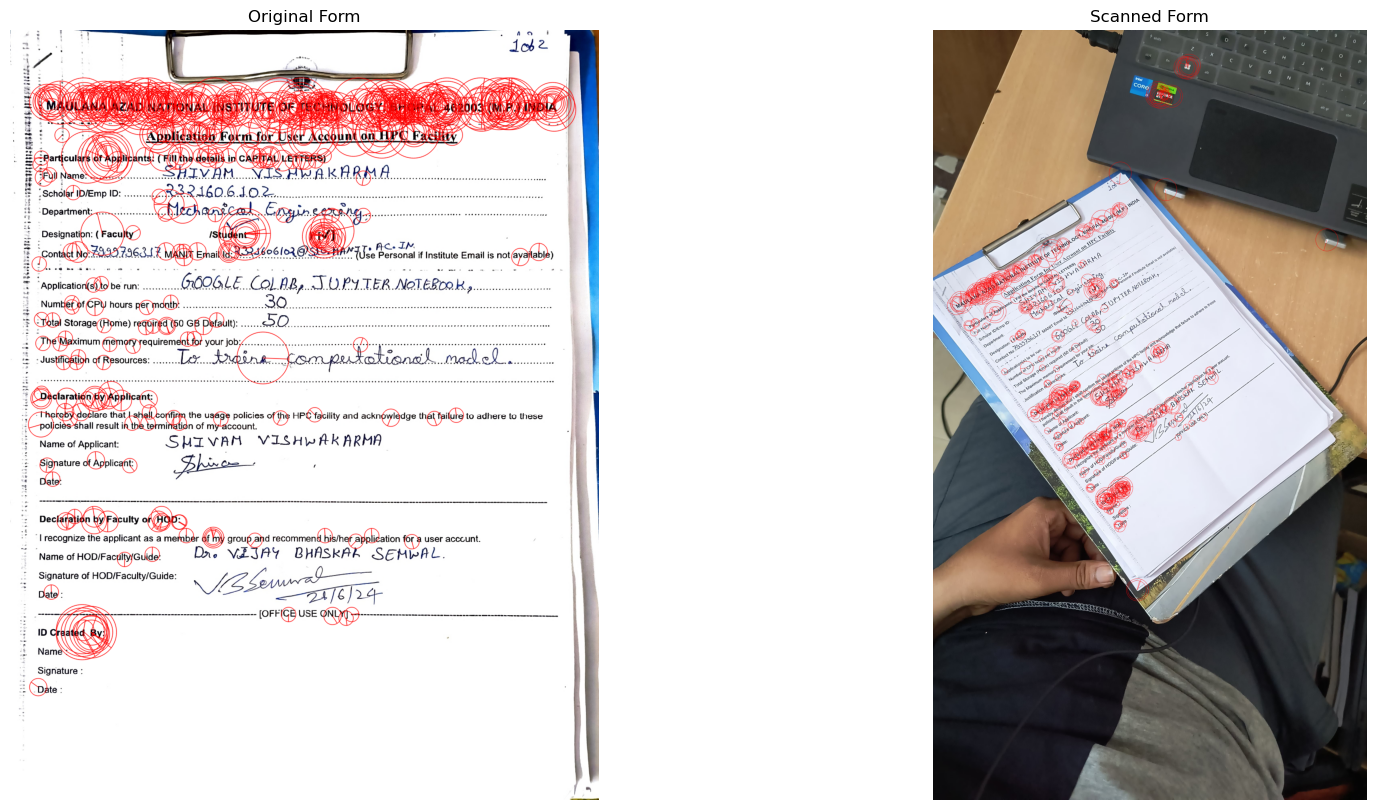

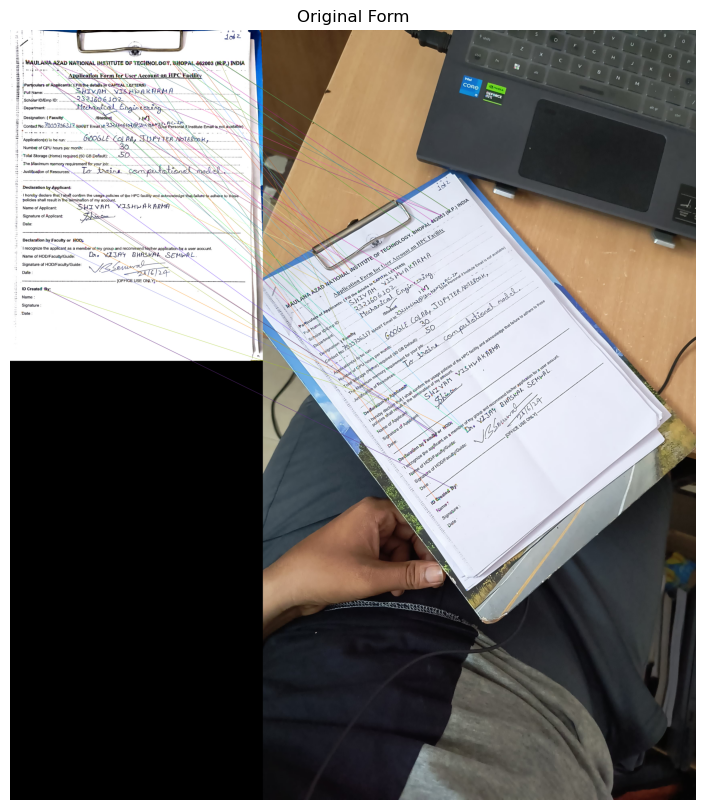

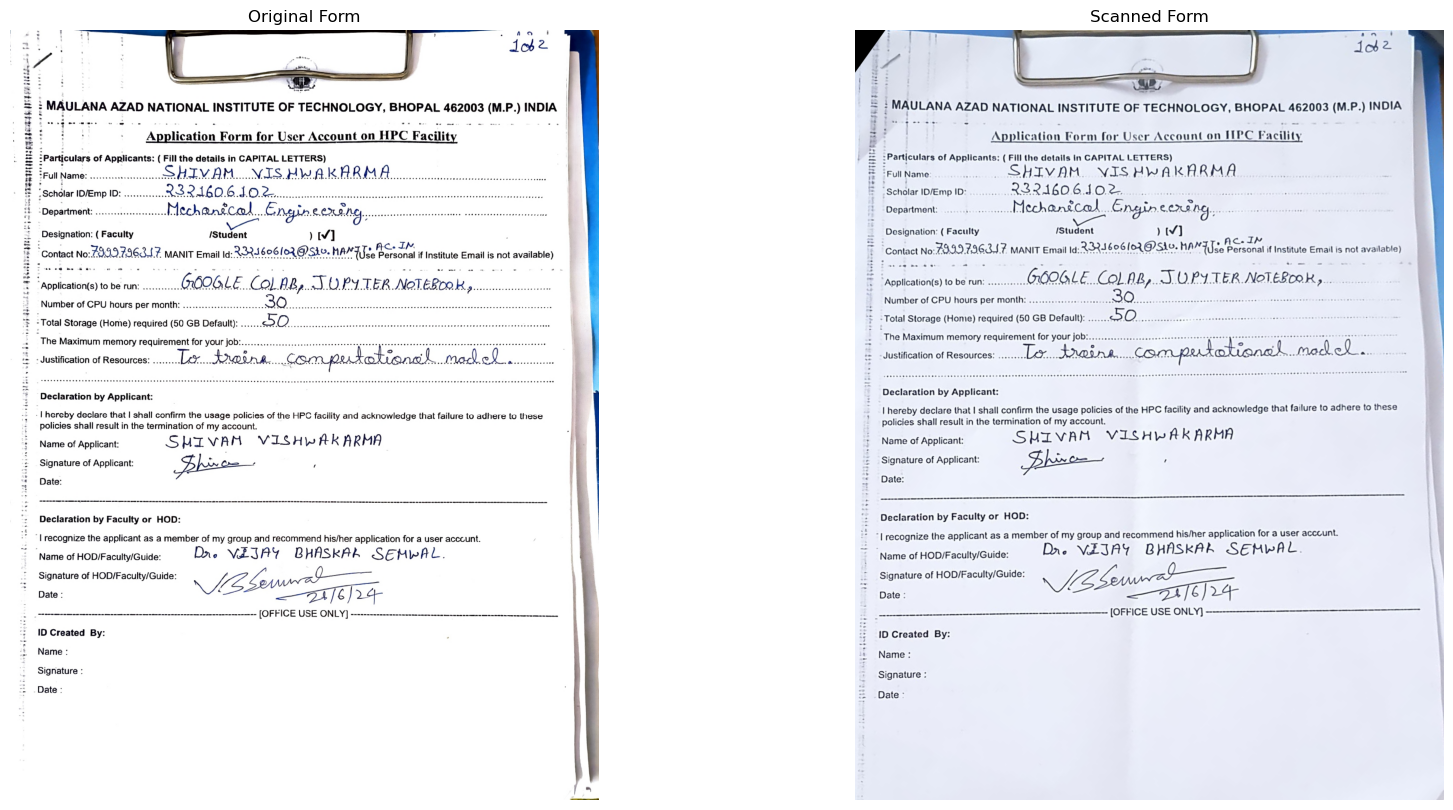

In [5]:
# Image Allignmet

# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
        
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)
    
    
# Read reference image
refFilename = "im1.jpg"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "im2.jpg"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


# Display Images

plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")


saved ldr-Drago.jpg
Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


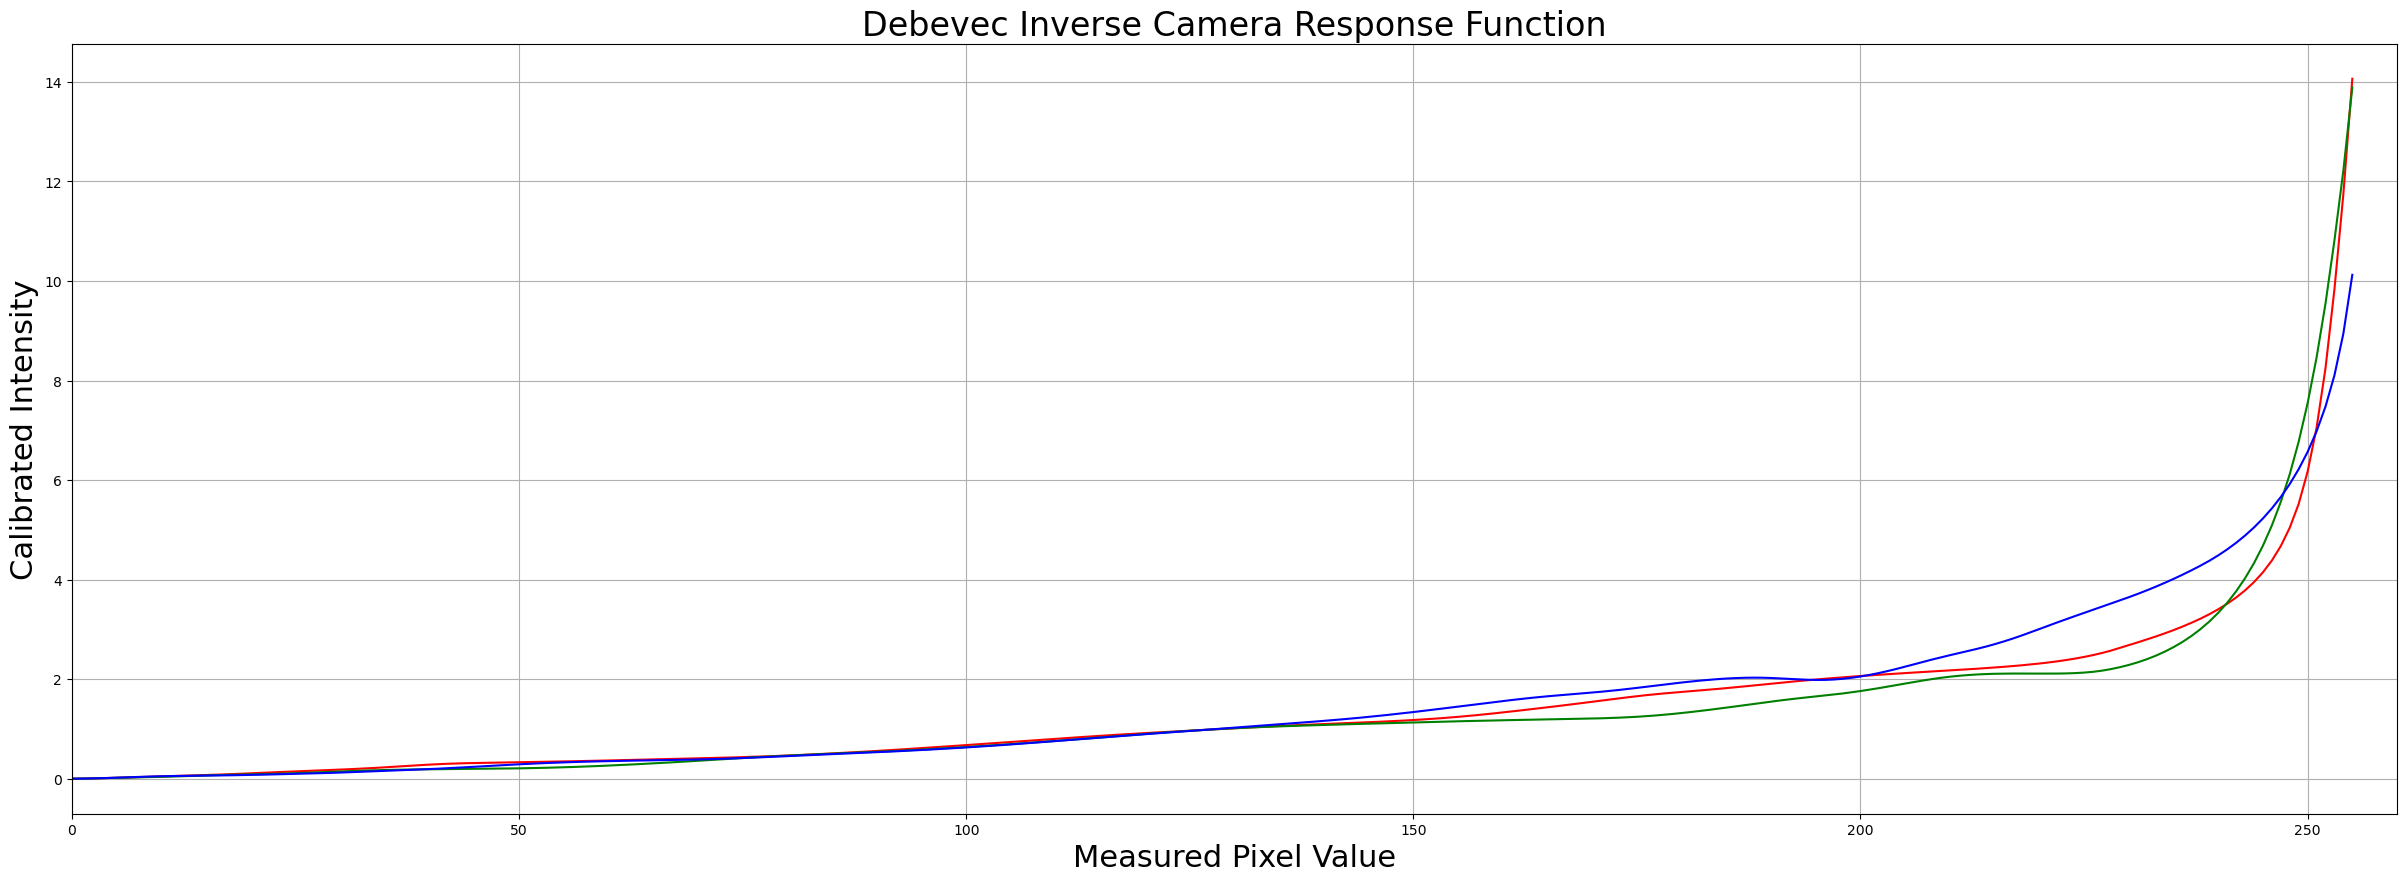

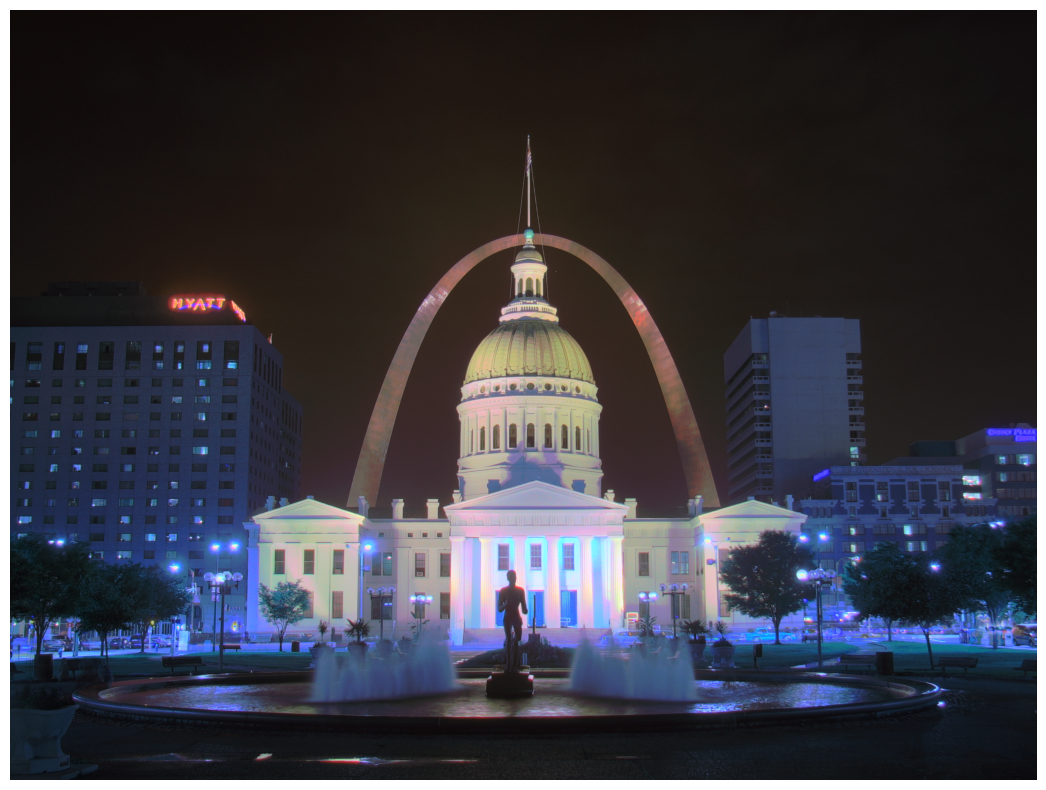

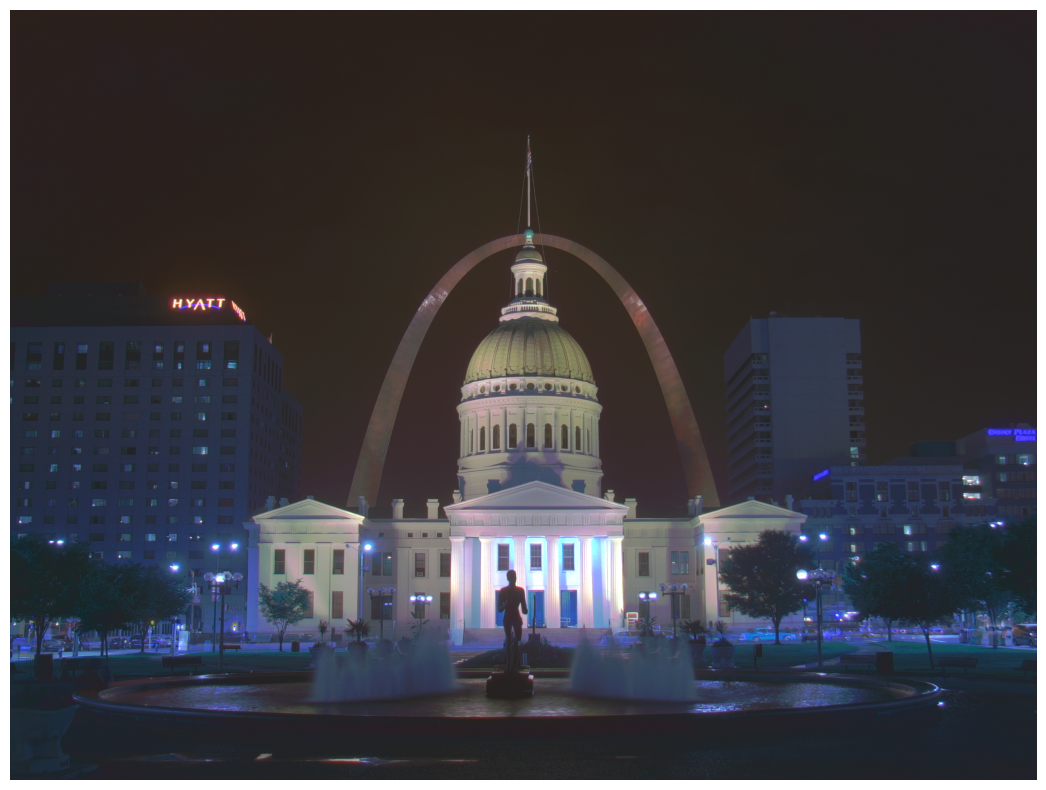

In [4]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
        
        
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)
    
def readImagesAndTimes():
    # List of file names
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)


# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "r", x, y[:, 1], "g", x, y[:, 2], "b")

# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago[:, :, ::-1])
print("saved ldr-Drago.jpg")

# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)
print("saved ldr-Mantiuk.jpg")

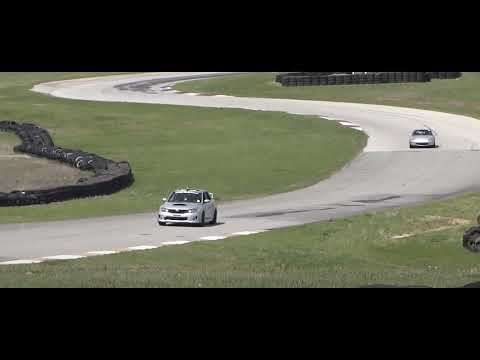

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'ffmpeg' is not recognized as an internal or external command,
operable program or batch file.


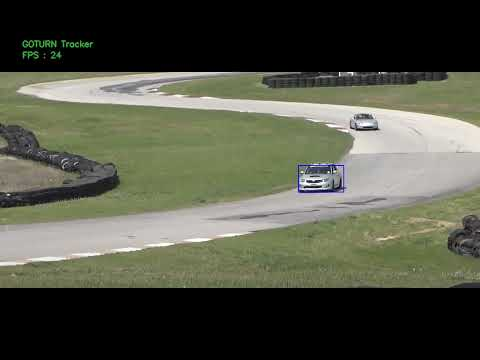

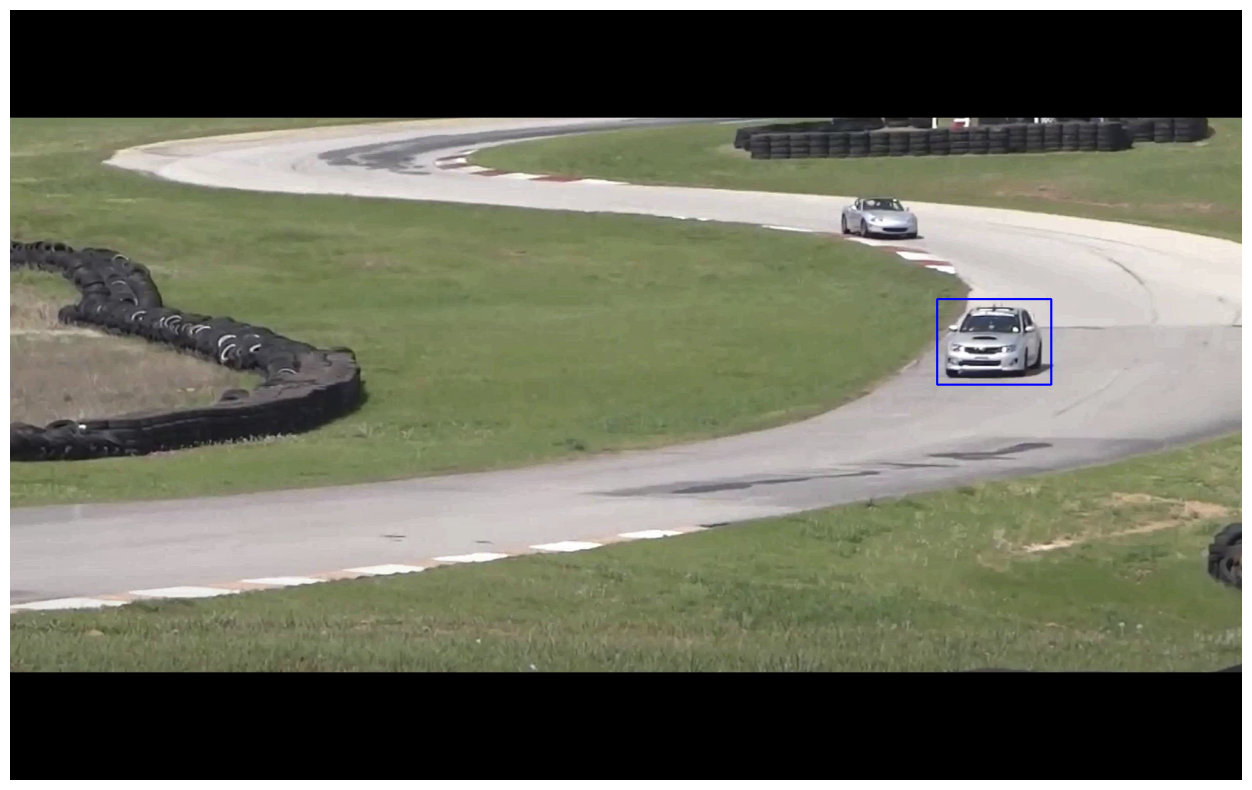

In [6]:
# Object Tracking

# import urllib

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
        
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)
    
video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
display(video)

video_input_file_name = "race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
    
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[6]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()
    
# Read video
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)


while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

# Installing ffmpeg
!apt-get -qq install ffmpeg 

# Change video encoding of mp4 file from XVID to h264 
!ffmpeg -y -i {video_output_file_name} -c:v libx264 $"race_car_track_x264.mp4"  -hide_banner -loglevel error

# mp4 = open("/content/race_car_track_x264.mp4", "rb").read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")

# Tracker: GOTURN
video = YouTubeVideo("0bnWxc4zMvY", width=1024, height=640)
display(video)

In [6]:
# Face Detection

import os
import cv2
import sys
from zipfile import ZipFile
from urllib.request import urlretrieve

# ========================-Downloading Assets-========================
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)


URL = r"https://www.dropbox.com/s/efitgt363ada95a/opencv_bootcamp_assets_12.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_12.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

    
# ========================-Downloading Assets-========================
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)


URL = r"https://www.dropbox.com/s/efitgt363ada95a/opencv_bootcamp_assets_12.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_12.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)
    
s = 0
if len(sys.argv) > 1:
    s = sys.argv[1]

source = cv2.VideoCapture(s)

win_name = "Camera Preview"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000_fp16.caffemodel")
# Model parameters
in_width = 300
in_height = 300
mean = [104, 117, 123]
conf_threshold = 0.7

while cv2.waitKey(1) != 27:
    has_frame, frame = source.read()
    if not has_frame:
        break
    frame = cv2.flip(frame, 1)
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1.0, (in_width, in_height), mean, swapRB=False, crop=False)
    # Run a model
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x_left_bottom = int(detections[0, 0, i, 3] * frame_width)
            y_left_bottom = int(detections[0, 0, i, 4] * frame_height)
            x_right_top = int(detections[0, 0, i, 5] * frame_width)
            y_right_top = int(detections[0, 0, i, 6] * frame_height)

            cv2.rectangle(frame, (x_left_bottom, y_left_bottom), (x_right_top, y_right_top), (0, 255, 0))
            label = "Confidence: %.4f" % confidence
            label_size, base_line = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            cv2.rectangle(
                frame,
                (x_left_bottom, y_left_bottom - label_size[1]),
                (x_left_bottom + label_size[0], y_left_bottom + base_line),
                (255, 255, 255),
                cv2.FILLED,
            )
            cv2.putText(frame, label, (x_left_bottom, y_left_bottom), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    t, _ = net.getPerfProfile()
    label = "Inference time: %.2f ms" % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))
    cv2.imshow(win_name, frame)

source.release()
cv2.destroyWindow(win_name)


                     Object detection




In [9]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [10]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [11]:
URL = r"https://www.dropbox.com/s/xoomeq2ids9551y/opencv_bootcamp_assets_NB13.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB13.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

In [13]:
classFile  = "coco_class_labels.txt"

with open(classFile) as fp:
    labels = fp.read().split("\n")
    
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


In [15]:
modelFile  = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29", "frozen_inference_graph.pb")
configFile = os.path.join("models", "ssd_mobilenet_v2_coco_2018_03_29.pbtxt")

# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

In [16]:
# For ach file in the directory
def detect_objects(net, im, dim = 300):

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0, 0, 0), swapRB=True, crop=False)

    # Pass blob to the network
    net.setInput(blob)

    # Peform Prediction
    objects = net.forward()
    return objects

In [19]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

In [20]:
def display_text(im, text, x, y):
    # Get text size
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]

    # Use text size to create a black rectangle
    cv2.rectangle(
        im,
        (x, y - dim[1] - baseline),
        (x + dim[0], y + baseline),
        (0, 0, 0),
        cv2.FILLED,
    )

    # Display text inside the rectangle
    cv2.putText(
        im,
        text,
        (x, y - 5),
        FONTFACE,
        FONT_SCALE,
        (0, 255, 255),
        THICKNESS,
        cv2.LINE_AA,
    )

In [21]:
def display_objects(im, objects, threshold=0.25):
    rows = im.shape[0]
    cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])

        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 10))
    plt.imshow(mp_img)
    plt.show()

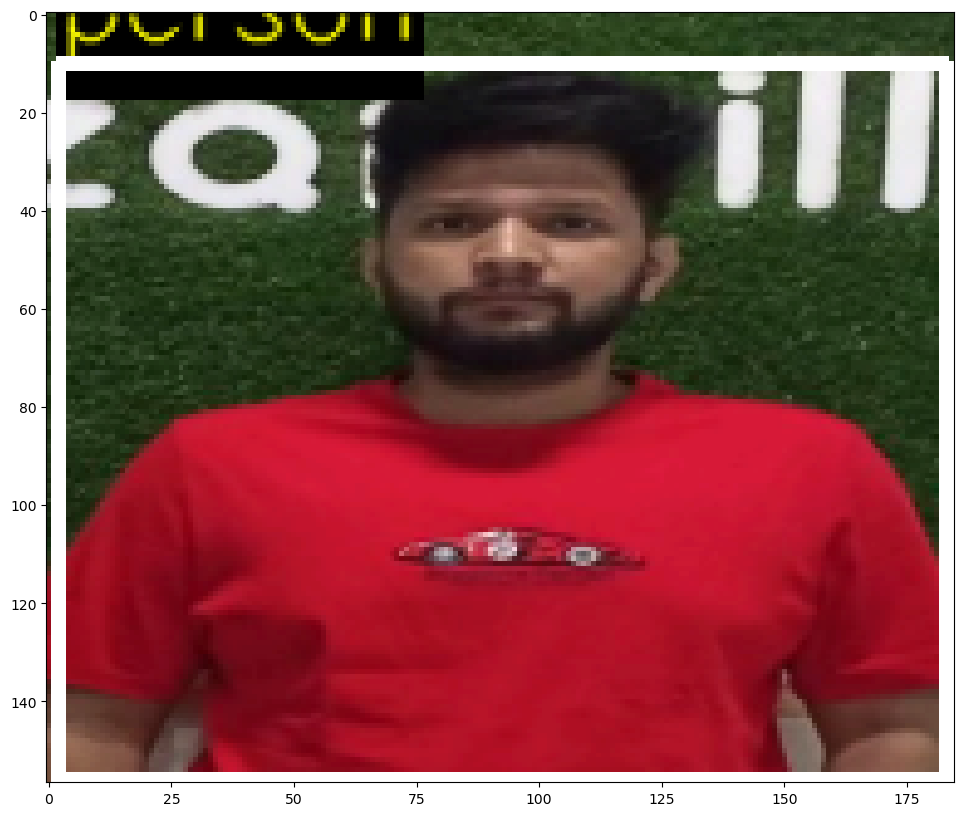

In [27]:
im = cv2.imread( "img2.png")
objects = detect_objects(net, im)
display_objects(im, objects)